In [1]:
import tensorflow as tf

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

import keras
import keras.backend as K

import tensorflow_probability as tfp

import sys
import numpy as np
from scipy.stats import levy_stable
import datetime

tfd = tfp.distributions

%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 1
step_size = 1e-2  # 5e-2 # step size
n_pts = 20000      # number of points

n_x=20 #number of different x

n_layers = 2
n_dim_per_layer = 25

n_dimensions = 1

ACTIVATIONS = tf.nn.elu
VALIDATION_SPLIT = .1
BATCH_SIZE = 100
#N_EPOCHS = 25

tf.random.set_seed(random_seed)

In [3]:
# data generation 

class SDEIntegrators:
    """
    Implements the common Euler-Maruyama 
    scheme used in integration of SDE.
    """

    def __init__(self):
        pass

    
    @staticmethod
    def euler_maruyama(xn, h, _f_sigma, rng):

        dW = rng.normal(loc=0, scale=np.sqrt(h), size=xn.shape)
        #np.random.seed(random_seed)
        dL = levy_stable.rvs(alpha=1, beta=0, size=xn.shape )#scale=h)    # added for levy 
        
        xk = xn.reshape(1, -1)  # we only allow a single point as input

        fk, sk = _f_sigma(xk)
        if np.prod(sk.shape) == xk.shape[-1]:
            skW = sk * dW
            skL = sk * dL *h 
        else:
            sk = sk.reshape(xk.shape[-1], xk.shape[-1])
            skW = (sk @ dW.T).T
            skL = ((sk @ dL.T).T)*h
        # return xk + h * fk + skW 
        return xk + h * fk + skL   # added for levy 

    
def sample_data(drift_diffusivity, step_size, n_dimensions, low, high, n_pts, rng, n_subsample=1,n_x=20):
    x_data=np.linspace(low,high,n_x+1)
    x_data=np.repeat(x_data[:-1],n_pts/n_x).reshape(-1,n_dimensions)
    y_data = x_data.copy()
    for k in range(n_subsample):
        y_data = np.row_stack([
            SDEIntegrators.euler_maruyama(y_data[k, :],
                                          step_size / n_subsample,
                                          drift_diffusivity,
                                          rng)
            for k in range(x_data.shape[0])
        ])

    return x_data, y_data


# EXAMPLE 1
def true_drift(x):
    return -x+1



def true_diffusivity(x):
    return (x+np.sqrt(25))*0.1 


def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=-3, high=3, n_pts=n_pts,
                             rng=rng)
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

data shape (20000, 1)


In [4]:
#neural network
def define_gaussian_process(n_input_dimensions, n_output_dimensions, n_layers, n_dim_per_layer, name,
                            activation="tanh", dtype=tf.float64):
    #mean
    inputs = layers.Input((n_input_dimensions,), dtype=dtype, name=name + '_inputs')
    gp_x = inputs
    for i in range(n_layers):
        gp_x = layers.Dense(n_dim_per_layer,
                            activation=activation,
                            dtype=dtype,
                            name=name + "_mean_hidden_{}".format(i))(gp_x)
    gp_output_mean = layers.Dense(n_output_dimensions, dtype=dtype,
                                  name=name + "_output_mean", activation=None)(gp_x)
    
        
    #std
    # initialize with extremely small (not zero!) values so that it does not dominate the drift
    # estimation at the beginning of training
    small_init = 1e-2
    initializer = tf.keras.initializers.RandomUniform(minval=-small_init, maxval=small_init, seed=None)

    gp_x = inputs
    for i in range(n_layers):
        gp_x = layers.Dense(n_dim_per_layer,
                            activation=activation,
                            dtype=dtype,
                            kernel_initializer=initializer,
                            bias_initializer=initializer,
                            name=name + "_std_hidden_{}".format(i))(gp_x)
        gp_output_std = layers.Dense(n_output_dimensions,
                                     kernel_initializer=initializer,
                                     bias_initializer=initializer,
                                     activation=lambda x: tf.nn.softplus(x) + STD_MIN_VALUE,
                                     name=name + "_output_std", dtype=dtype)(gp_x)
        
    gp = tf.keras.Model(inputs, [gp_output_mean, gp_output_std], name=name + "_gaussian_process")
    
    return gp
   

In [5]:
# Cauchy distribution in neural network
def define_normal_distribution(yn_, step_size_, drift_, diffusivity_):
#             added for levy
#             alpha = 1
#             beta = 0 
#             sigma = .1
#             gamma = 0
#             appro_levy =  sigma/math.pi*((x-gamma)**2 + sigma ** 2) 

        #Define a single scalar Cauchy distribution.
        approx_dist = tfd.Cauchy(loc= yn_ + step_size_ * drift_, 
                                 scale=tf.abs(step_size_ * diffusivity_))
        approx_normal = tfd.MultivariateNormalDiag(
            loc=(yn_ + step_size_ * drift_),
            scale_diag=tf.math.sqrt(step_size_) * diffusivity_,
            name="approx_normal"
        )
        return approx_dist

In [6]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    @staticmethod
    def __log(message, flush=True):
        sys.stdout.write(message)
        if flush:
            sys.stdout.flush()

    def on_train_batch_end(self, batch, logs=None):
        pass

    def on_test_batch_end(self, batch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        LossAndErrorPrintingCallback.__log(
            "\rThe average loss for epoch {} is {:7.10f} ".format(
                epoch, logs["loss"]
            )
        )

In [7]:
class SDEApproximationNetwork(tf.keras.Model):

    def __init__(self,
                 sde_model: tf.keras.Model,
                 step_size=None,
                 **kwargs):
        super().__init__(**kwargs)
        self.sde_model = sde_model
        self.step_size = step_size

    @staticmethod
    def euler_maruyama_pdf(ynp1_, yn_, step_size_, model_):

        drift_, diffusivity_ = model_(yn_)

        approx_normal = define_normal_distribution(yn_,
                                                step_size_,
                                                drift_,
                                                diffusivity_,)
        return approx_normal.log_prob(ynp1_)
    
    
    @staticmethod
    def euler_maruyama_loss(ynp1_, yn_, step_size_, model_):
        
        drift_, diffusivity_ = model_(yn_)
        loc= drift_*step_size_+yn_
        scale=tf.abs(step_size_*diffusivity_)
        

        return loc, scale


    @staticmethod
    def split_inputs(inputs, step_size=None):
        if step_size is None:
            n_size = (inputs.shape[1] - 1) // 2
            step_size, x_n, x_np1 = tf.split(inputs, num_or_size_splits=[1, n_size, n_size], axis=1)
        else:
            step_size = step_size
            x_n, x_np1 = tf.split(inputs, num_or_size_splits=2, axis=1)
        return step_size, x_n, x_np1

    def call_xn(self, inputs_xn):

        return self.sde_model(inputs_xn)

    def call(self, inputs):

        step_size, x_n, x_np1 = SDEApproximationNetwork.split_inputs(inputs, self.step_size)


        log_prob = SDEApproximationNetwork.euler_maruyama_pdf(x_np1, x_n, step_size, self.sde_model,)
        approx_loc , approx_scale = SDEApproximationNetwork.euler_maruyama_loss(x_np1, x_n, step_size, self.sde_model)


        sample_distortion = -tf.reduce_mean(log_prob, axis=-1)
        distortion = tf.reduce_mean(sample_distortion)
        
        #add loc
        sample_distortion1 = tf.reduce_mean(tf.abs(x_np1-approx_loc), axis=-1)
        distortion1 = tf.reduce_mean(sample_distortion1)
        

        loss = distortion1

        self.add_loss(loss)
        self.add_metric(distortion, name="distortion", aggregation="mean")

        return self.sde_model(x_n)


In [8]:
STD_MIN_VALUE = 1e-13
tf.keras.backend.set_floatx('float64')
NUMBER_TYPE = tf.float64

# define the neural network model we will use for identification
encoder = define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder)
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005))
model.compile(optimizer=tf.keras.optimizers.Adamax())


Model: "GP_gaussian_process"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GP_inputs (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
GP_mean_hidden_0 (Dense)        (None, 25)           50          GP_inputs[0][0]                  
__________________________________________________________________________________________________
GP_std_hidden_0 (Dense)         (None, 25)           50          GP_inputs[0][0]                  
__________________________________________________________________________________________________
GP_mean_hidden_1 (Dense)        (None, 25)           650         GP_mean_hidden_0[0][0]           
________________________________________________________________________________

training for 100 epochs with 18000 data points, validating with 2000
The average loss for epoch 99 is 0.0644961639 <tensorflow.python.keras.callbacks.History object at 0x00000209B9305FD0>


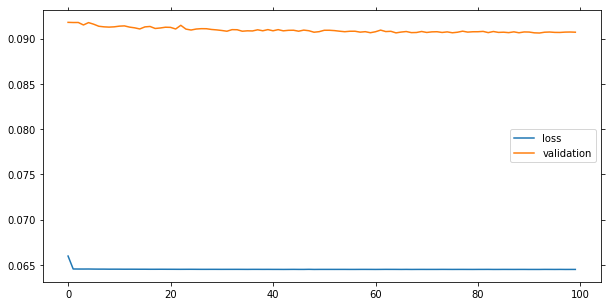

In [9]:
# train model
x_n = x_data
x_np1 = y_data
n_epochs = 100
callbacks = []


print(f"training for {n_epochs} epochs with {int(x_n.shape[0] * (1 - VALIDATION_SPLIT))} data points"
      f", validating with {int(x_n.shape[0] * VALIDATION_SPLIT)}")

if not (step_size is None):
    x_n = np.column_stack([step_sizes, x_n])
y_full = np.column_stack([x_n, x_np1])

if len(callbacks) == 0:
    callbacks.append(LossAndErrorPrintingCallback())

hist = model.fit(x=y_full,
                      epochs=n_epochs,
                      batch_size=BATCH_SIZE,
                      verbose=0,
                      validation_split=VALIDATION_SPLIT,
                      callbacks=callbacks)
        
print(hist)

    
fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss')
hist_axes.plot(hist.history["val_loss"], label='validation')
hist_axes.legend()


In [10]:
#estimated drift,diffusivity
def drift_diffusivity(x):
    drift, std = model.call_xn(x)
    return K.eval(drift), K.eval(std)
    
mean_network, std_network = drift_diffusivity(x_data.astype(np.float32))  

In [11]:
#direct calculate for diffusion
mu=mean_network*step_size+x_data
sigma_multi_hat=[]
for i in range(n_x):
    low=np.int_(i*(n_pts/n_x));high=np.int_((i+1)*(n_pts/n_x))
    sigma_h=(1/2)*(tf.reduce_sum(tf.sqrt(tf.abs((y_data-mu)[low:high,:])))*(n_x/n_pts))**2
    sigma_hat=(sigma_h/step_size).numpy()
    sigma_multi_hat.append(sigma_hat)
    
print(mu,sigma_multi_hat)



approx_std = tf.convert_to_tensor(np.array(sigma_multi_hat).repeat(np.int(n_pts/n_x)))
approx_mean = tf.convert_to_tensor(mean_network)

std_coeff = np.polyfit(np.sort(x_data.ravel()), approx_std, 1)
p1 = np.poly1d(std_coeff)
std_fitting = p1(x_data[:,0])

[[-2.96021054]
 [-2.96021054]
 [-2.96021054]
 ...
 [ 2.6848999 ]
 [ 2.6848999 ]
 [ 2.6848999 ]] [0.19876700956640125, 0.24379464023326353, 0.2678482309740147, 0.33115220253137007, 0.2900672725390035, 0.3480884057423071, 0.3686009374951001, 0.740383025991932, 0.4084470599253499, 0.6197477173870936, 0.4627968741107749, 0.5109960083375764, 0.5490652352671189, 0.516027108002983, 0.5926021206178776, 0.6667437310537658, 0.8539863625184866, 0.633047960780529, 0.9232115091356413, 0.7786305023318432]


In [12]:
def approx_result(a, b):
    return a, b

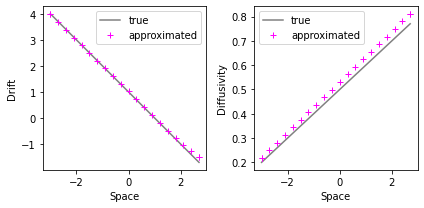

In [13]:
def plot_results_functions1(apx_drift_diffusivity, true_drift_diffusivity,
                           x_data, y_data, rng):


    mean_network, std_network = apx_drift_diffusivity

    mean_network = keras.backend.eval(mean_network)
    std_network = keras.backend.eval(std_network)

    n_dimensions = x_data.shape[1]  

    ms = 0.25  # marker size

    true_drift_evaluated, true_std_evaluated = true_drift_diffusivity(x_data)

    if n_dimensions == 1:
        mean_network = mean_network.reshape(-1, 1)
        std_network = std_network.reshape(-1, 1)
        
        idx_ = np.argsort(x_data.ravel()) 

        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        ax[0].plot(x_data[idx_], true_drift_evaluated[idx_], "-", color="gray", label="true")
        ax[0].plot(x_data[idx_], mean_network[idx_, 0], "+", markevery=len(x_data)//21, color='magenta', label="approximated")   
        ax[0].set_xlabel("Space")
        ax[0].set_ylabel("Drift")
        ax[0].legend()

        ax[1].plot(x_data[idx_], true_std_evaluated[idx_], "-", color="gray", label="true")
        ax[1].plot(x_data[idx_], std_network[:, 0], "+", markevery=len(x_data)//21, color='magenta', label="approximated")
        ax[1].set_xlabel("Space")
        ax[1].set_ylabel("Diffusivity")
        ax[1].legend()
    else:
        fig, ax = plt.subplots(2, n_dimensions, figsize=(n_dimensions * 3, 6))

        for k in range(n_dimensions):
            identity_pts = np.linspace(np.min([np.min(mean_network[:, k]), np.min(true_drift_evaluated)]),
                                       np.max([np.max(mean_network[:, k]), np.max(true_drift_evaluated)]),
                                       10)

            ax[0, k].scatter(mean_network[:, k], true_drift_evaluated[:, k], s=ms, label="approximation")
            ax[0, k].plot(identity_pts, identity_pts, 'k--', label="identity")
            ax[0, k].set_xlabel(r"network drift $f_" + str(k + 1) + "$")
            ax[0, k].set_ylabel(r"true drift $f_" + str(k + 1) + "$")
            ax[0, k].legend()

            identity_pts = np.linspace(np.min([np.min(std_network[:, k]), np.min(true_std_evaluated)]),
                                       np.max([np.max(std_network[:, k]), np.max(true_std_evaluated)]),
                                       10)

            ax[1, k].scatter(std_network[:, k], true_std_evaluated[:, k], s=ms, label="approximation")
            ax[1, k].plot(identity_pts, identity_pts, 'k--', label="identity")
            ax[1, k].set_xlabel(r"network diffusivity $\sigma_" + str(k + 1) + "$")
            ax[1, k].set_ylabel(r"true diffusivity $\sigma_" + str(k + 1) + "$")
            ax[1, k].legend()
    fig.tight_layout() 
#     fig.savefig('_x+1-multi.eps',dpi=900,format='eps')
    return ax

rng = np.random.default_rng(random_seed)

ax = plot_results_functions1(approx_result(approx_mean, std_fitting), true_drift_diffusivity,
                            x_data, y_data, rng)




In [14]:
#L2loss
L2lossf=np.sum((mean_network-true_drift(x_data))**2)/n_pts;L2lossf
L2lossg=np.sum((sigma_multi_hat-true_diffusivity(np.linspace(-5,5,21)[:-1]))**2)/n_x;L2lossg

0.023179064753032493